In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from glob import glob
from matplotlib.colors import LogNorm

ftype = '.pdf'

In [2]:
import matplotlib

matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [13]:
gdir = '/Users/james/Dropbox/research_projects/TESS-Gaia/'
tess_dir = '/Users/james/Desktop/helloTESS/'

In [7]:
gfiles = glob(gdir+'*1arsec-result.csv')

gaia = pd.concat((pd.read_csv(f) for f in gfiles), ignore_index=True, sort=False)

In [17]:
rot_files = glob(tess_dir+'outputs/sector*rot*')

rot = pd.concat((pd.read_csv(f) for f in rot_files), ignore_index=True, sort=False)

In [24]:
gaia.columns.values

array(['solution_id', 'designation', 'source_id', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pmra', 'pmra_error',
       'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr',
       'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr',
       'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr',
       'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al',
       'astrometric_n_obs_ac', 'astrometric_n_good_obs_al',
       'astrometric_n_bad_obs_al', 'astrometric_gof_al',
       'astrometric_chi2_al', 'astrometric_excess_noise',
       'astrometric_excess_noise_sig', 'astrometric_params_solved',
       'astrometric_primary_flag', 'astrometric_weight_al',
       'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error',
       'mean_varpi_factor_al', 'astrometric_matched_observations',
       'visibility_periods_used', 'astrometric_sigma5d_max',
       'frame_rotator_object

In [69]:
gdata_big = pd.merge(rot, gaia, left_on='TIC', right_on='ticid', how='inner')

In [70]:
# this simple merge looks "broken" because so many stars are being observed in multiple Sectors (overlaps)
print(gaia.shape, rot.shape, gdata_big.shape)

(269060, 126) (227796, 12) (1086840, 138)


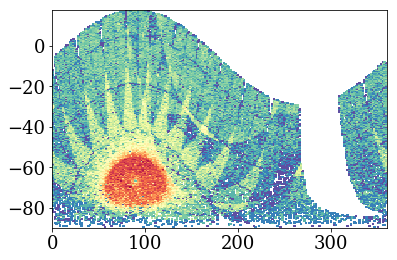

In [71]:
_ = plt.hist2d(gdata_big['ra'], gdata_big['dec'], bins=(200,200), cmap=plt.cm.Spectral_r, norm=LogNorm())

In [72]:
gdata_1 = gdata_big.drop_duplicates(subset='ticid').sort_values(by='TIC')
gdata_1.shape

(111298, 138)

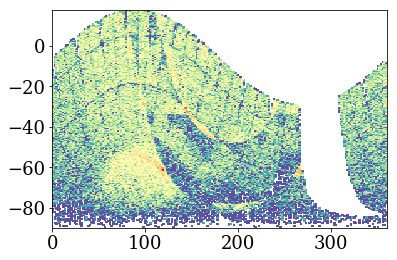

In [73]:
_ = plt.hist2d(gdata_1['ra'], gdata_1['dec'], bins=(200,200), cmap=plt.cm.Spectral_r, norm=LogNorm())

In [74]:
gdata = gdata_big.groupby('TIC').mean().sort_values(by='TIC')

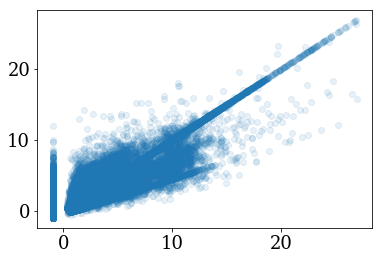

In [75]:
plt.scatter(gdata_1['acf_per'], gdata['acf_per'], alpha=0.1)

In [99]:
dPer = 0.15 # period agreement

ok = np.where(np.isfinite(gdata[u'parallax']) & # this is basically the same as the TGAS file...
              (gdata[u'parallax_error'] / gdata[u'parallax'] < 0.1) &
              (gdata[u'modality_flag'] == 1) & 
              (gdata[u'result_flag'] == 1) &
              np.isfinite(gdata[u'bp_rp']) & 
              (gdata[u'phot_bp_mean_flux_error']/gdata[u'phot_bp_mean_flux'] < 0.01) & 
              (gdata[u'phot_rp_mean_flux_error']/gdata[u'phot_rp_mean_flux'] < 0.01) & 
              (gdata[u'phot_g_mean_flux_error']/gdata[u'phot_g_mean_flux'] < 0.01) & 
              (gdata['acf_per'] > 0) & 
              (gdata['acf_per'] < 28) & 
              (((gdata['acf_per'].values / gdata['LSper'].values > 1-dPer) & 
                 (gdata['acf_per'].values / gdata['LSper'].values <= 1+dPer)) | 
                ((gdata['acf_per'].values / gdata['LSper'].values/2 > 1-dPer) & 
                 (gdata['acf_per'].values / gdata['LSper'].values/2 <= 1+dPer)) | 
               ((gdata['acf_per'].values / gdata['LSper'].values/3 > 1-dPer) & 
                 (gdata['acf_per'].values / gdata['LSper'].values/3 <= 1+dPer)) #|
#                 ((gdata['acf_per'].values / gdata['bls_per'].values/2 > 1-dPer) & 
#                  (gdata['acf_per'].values / gdata['bls_per'].values/2 <= 1+dPer))
               )
             )[0]

print(ok.shape)

(30558,)


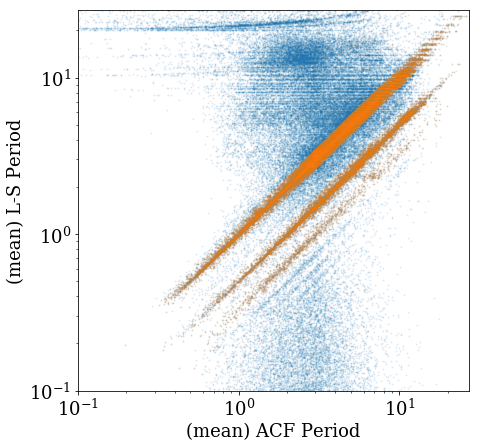

In [97]:
plt.figure(figsize=(7,7))
plt.scatter(gdata['acf_per'], gdata['LSper'], alpha=0.1, s=1)
plt.scatter(gdata['acf_per'].values[ok], gdata['LSper'].values[ok], alpha=0.1, s=1)
plt.xlabel('(mean) ACF Period')
plt.ylabel('(mean) L-S Period')
plt.xlim(0.1,27)
plt.ylim(0.1,27)
plt.xscale('log')
plt.yscale('log')

/Users/james/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Text(0.5, 1.0, 'TESS Sectors 1–12, N=30558')

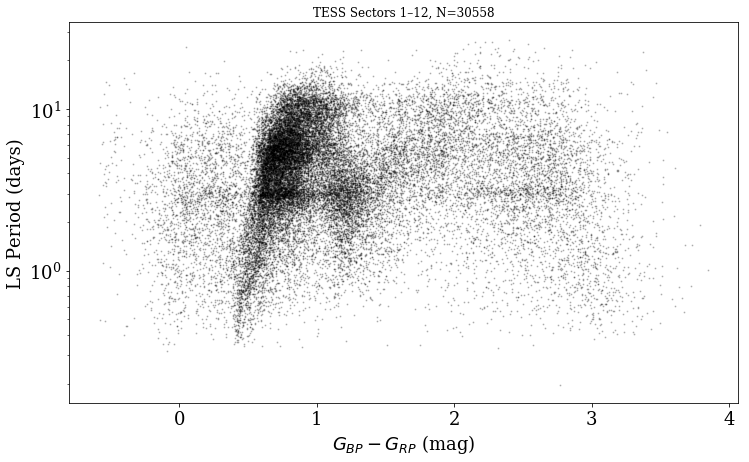

In [106]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok], gdata['acf_per'].values[ok], s=1, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1–12, N='+str(len(gdata['ticid'][ok])), fontsize=12)

(15, -5)

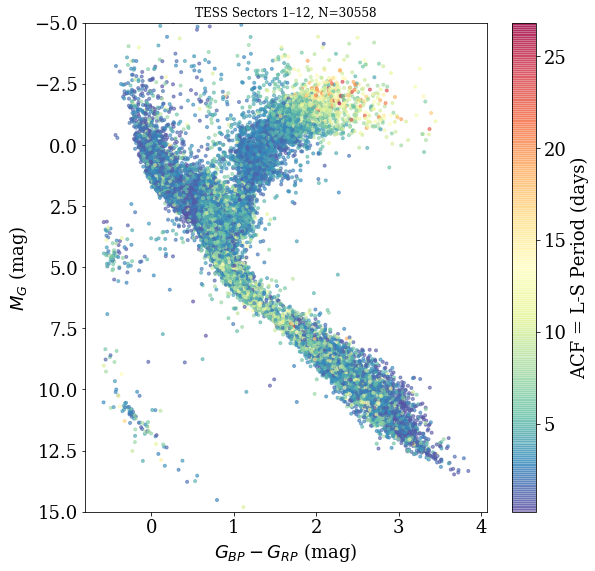

In [105]:

plt.figure(figsize=(9,9))

plt.scatter(gdata['bp_rp'].values[ok], 
            gdata['phot_g_mean_mag'].values[ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5, 
            alpha=0.6, s=9, c=(gdata['acf_per'].values[ok]), 
            cmap=plt.cm.Spectral_r)

cbar = plt.colorbar()
cbar.set_label('ACF = L-S Period (days)')

plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.ylabel('$M_G$ (mag)')
plt.title('TESS Sectors 1–12, N='+str(len(gdata['ticid'][ok])), fontsize=12)
plt.ylim(15,-5)

# plt.savefig('cmd_per.jpeg', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [107]:
msbad = np.where((gdata['phot_g_mean_mag'].values[ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 > 4) & 
                 (gdata['phot_g_mean_mag'].values[ok] - 5. * np.log10(gdata[u'r_est'].values[ok]) + 5 < 15) & 
                 (gdata['bp_rp'].values[ok] > 0.5))[0]

msbad.shape

(14143,)

Text(0.5, 1.0, 'TESS Sectors 1–12, N=14143')

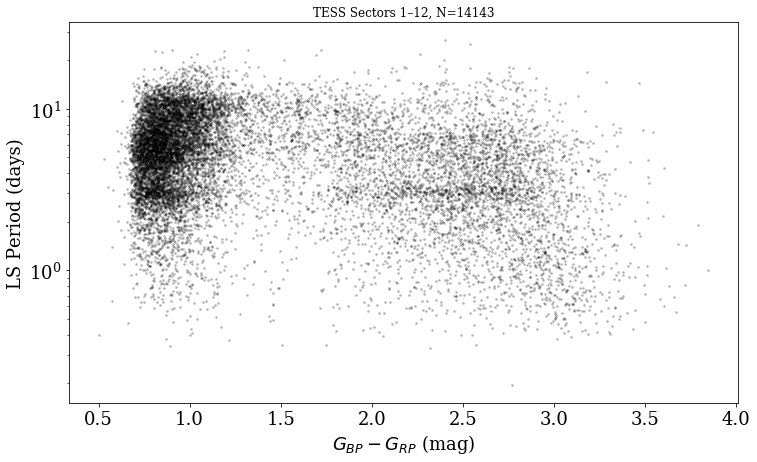

In [111]:
plt.figure(figsize=(12,7))
plt.scatter(gdata['bp_rp'].values[ok][msbad], gdata['acf_per'].values[ok][msbad], s=3, alpha=0.2, c='k')
plt.yscale('log')
plt.ylabel('LS Period (days)')
plt.xlabel('$G_{BP} - G_{RP}$ (mag)')
plt.title('TESS Sectors 1–12, N='+str(len(gdata['ticid'][ok][msbad])), fontsize=12)